In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np

def detect_task_board(image):
    """
    Detects a black task board using grayscale thresholding and contour detection.

    Parameters:
    - image: BGR image from the camera.

    Returns:
    - Bounding box (x_min, y_min, x_max, y_max) if detected, else None.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to highlight the dark areas
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 5)

    # Apply morphological operations to remove small noise
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None  # No board detected

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    return (x, y, x + w, y + h)  # Bounding box format (x_min, y_min, x_max, y_max)



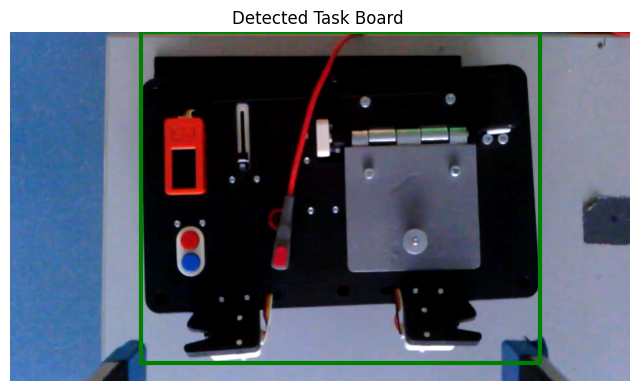

In [5]:
image = cv2.imread("task_1_bag_2_data/image_525.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
bbox = detect_task_board(image)

# Plot results
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)  # Show image in RGB format
plt.axis("off")

# Draw bounding box if detected
if bbox:
    x_min, y_min, x_max, y_max = bbox
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                      edgecolor='green', linewidth=3, fill=False))
    plt.title(f"Detected Task Board ")
else:
    plt.title("Task board not detected!")

plt.show()

True

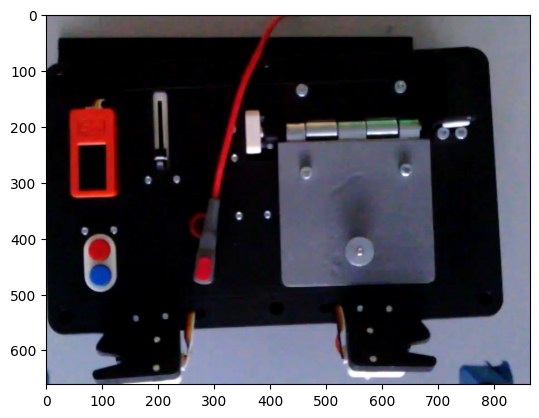

In [47]:
cropped_image = image_rgb[y_min:y_max, x_min:x_max]
plt.imshow(cropped_image)
cv2.imwrite("task_board_template.png", cropped_image)

In [8]:
import cv2
import numpy as np

def compute_match_score(image, template_path='task_board_template.png'):
    """
    Computes the match score between the input image and the template.
    The score is based on the number of good keypoint matches.

    Parameters:
    - image: The current image to check for the task board.
    - template_path: Path to the template image of the task board.

    Returns:
    - match_score: A float representing the match score (0 to 1).
    - bbox: The bounding box (x_min, y_min, x_max, y_max) of the detected task board.
    """
    # Load the template and convert it to grayscale
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use ORB detector to find keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(template, None)
    kp2, des2 = orb.detectAndCompute(gray_image, None)

    # Use BFMatcher to match descriptors between image and template
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Calculate the match score (number of good matches / total number of template keypoints)
    good_matches = len(matches)
    total_keypoints = len(kp1)

    # Calculate match score as the ratio of good matches to total keypoints in the template
    match_score = good_matches / total_keypoints if total_keypoints > 0 else 0

    # Estimate the bounding box of the matched area
    if good_matches > 10:  # Check if we have enough matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Find homography to align the template to the detected region
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the size of the template
        h, w = template.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        # Get bounding box from transformed points
        x_min, y_min = np.min(dst, axis=0).flatten()
        x_max, y_max = np.max(dst, axis=0).flatten()

        bbox = (int(x_min), int(y_min), int(x_max), int(y_max))
    else:
        bbox = None

    return match_score, bbox


def compute_reward(image):
    """
    Computes the reward based on the match score and provides a reward value.
    The reward is higher when more of the task board is visible (better match).
    """
    match_score, bbox = compute_match_score(image)
    
    # Calculate the reward
    reward = match_score  # Match score directly used as reward (scaled 0-1)
    
    # If there is no match, reward is zero
    if match_score < 0.1:
        reward = 0
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)  # Show image in RGB format
    plt.axis("off")

    # Draw bounding box if detected
    if bbox:
        x_min, y_min, x_max, y_max = bbox
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                        edgecolor='green', linewidth=3, fill=False))
        plt.title(f"Detected Task Board - Reward: {reward}")
    else:
        plt.title("Task board not detected!")

    plt.show()
    return reward, bbox




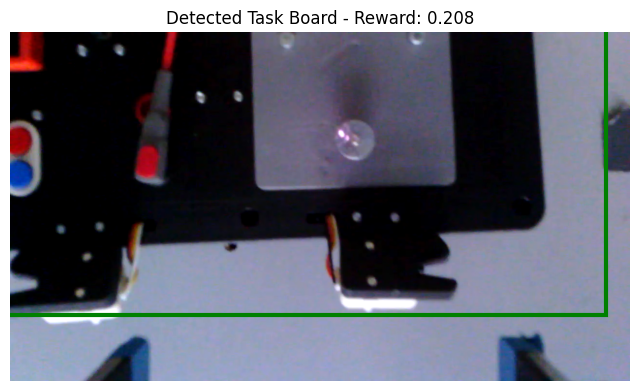

In [63]:
image = cv2.imread("task_1_bag_2_data/image_177.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)


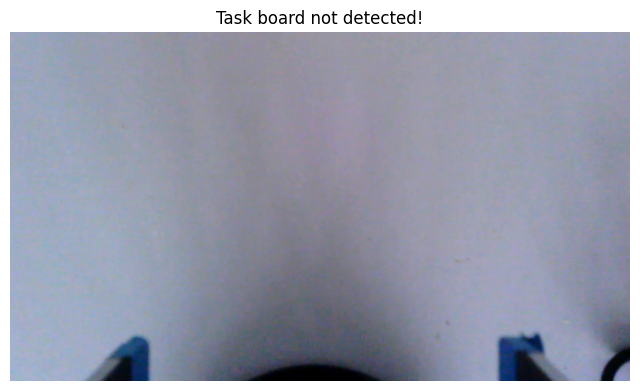

In [64]:
image = cv2.imread("task_1_bag_2_data/image_007.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)



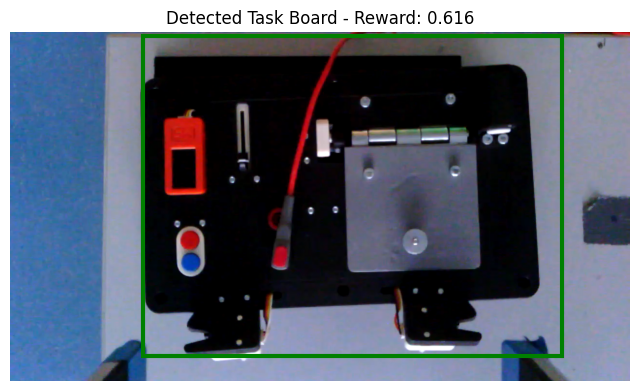

In [65]:
image = cv2.imread("task_1_bag_2_data/image_525.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)


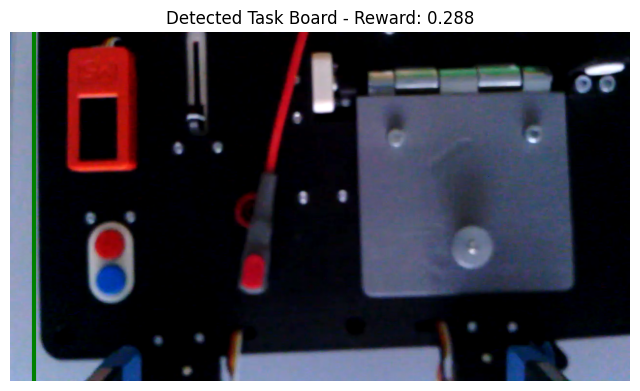

In [66]:
image = cv2.imread("task_1_bag_2_data/image_220.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)



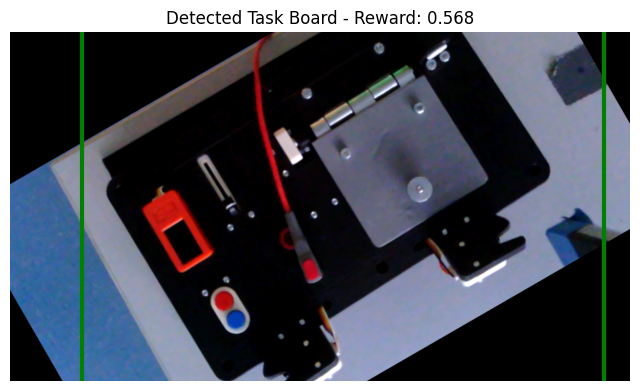

In [10]:
def rotate_image(image, angle):
    # Get the image dimensions (height, width)
    (h, w) = image.shape[:2]
    # Compute the center of the image
    center = (w // 2, h // 2)
    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    
    return rotated_image

image = cv2.imread("task_1_bag_2_data/image_525.png")
image = rotate_image(image, 30)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)

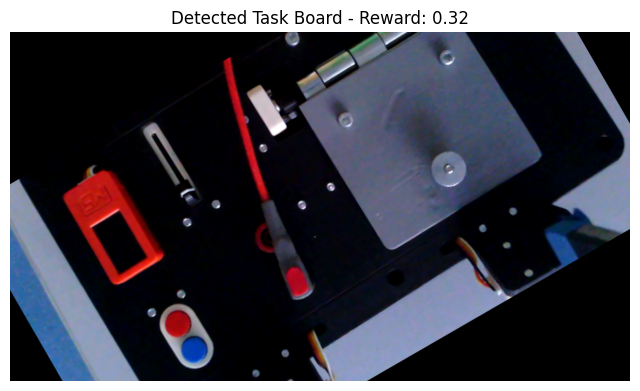

In [11]:
image = cv2.imread("task_1_bag_2_data/image_270.png")
image = rotate_image(image, 30)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Compute reward and detect task board
reward, bbox = compute_reward(image)